<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CGE-Lamp5"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/CGE-Lamp5/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


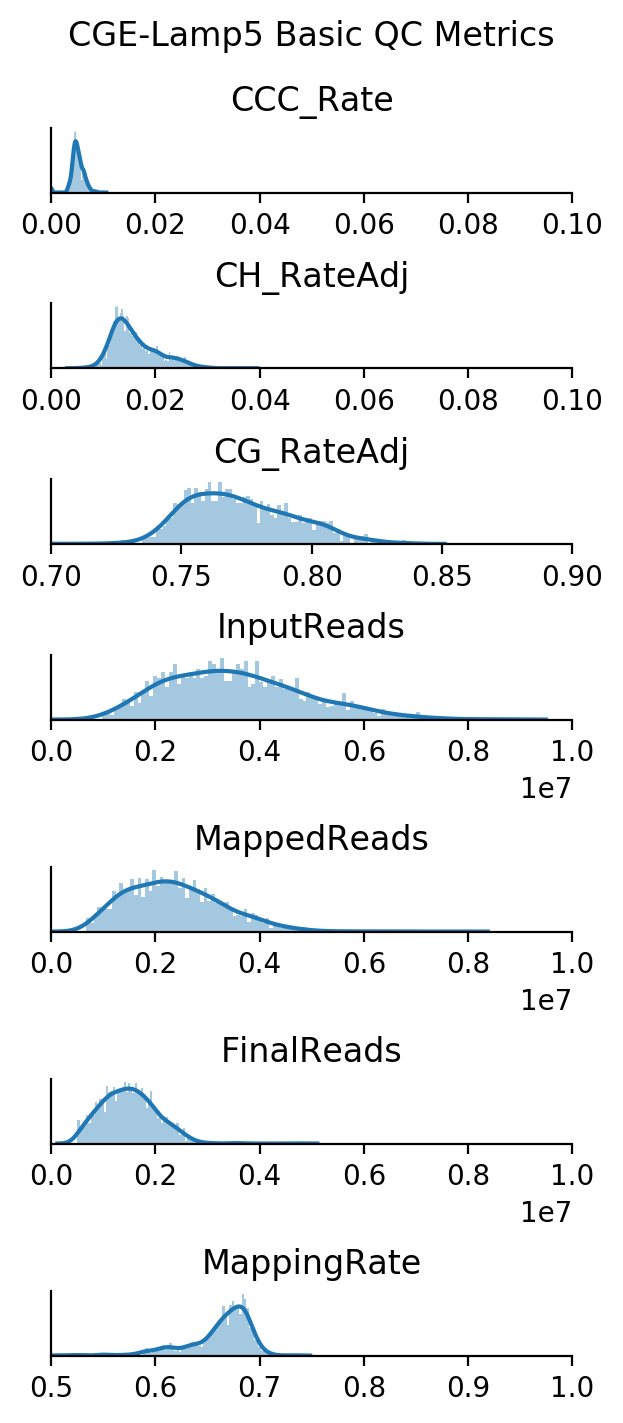

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

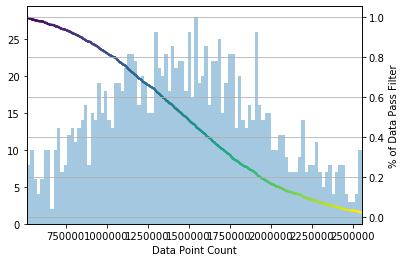

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1449/1449 (100.0%)
CG_RateAdj passed 1449/1449 (100.0%)
CH_RateAdj passed 1449/1449 (100.0%)
FinalReads passed 1449/1449 (100.0%)
MappingRate passed 1449/1449 (100.0%)
Overall passed 1449/1449 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 32
171207 40
171212 3
171213 34
171214 2
171219 2
180104 42
180109 2
180110 1
180119 43
180122 29
180123 23
180129 10
180130 27
180205 14
180206 27
180208 3
180212 12
180213 34
180220 20
180222 19
180226 51
180227 47
180305 24
180306 40
180312 17
180313 9
180319 7
180320 12
180326 15
180329 14
180402 19
180403 16
180405 4
180409 64
180410 58
180412 13
180416 15
180417 31
180419 17
180423 16
180424 19
180426 16
180430 23
180501 27
180514 15
180529 28
180605 26
180612 28
180806 2
180911 1
180917 1
181002 27
181008 13
181009 20
181015 2
181022 27
181023 19
181204 1
181206 2
181210 33
181218 1
181220 4
190108 9
190117 13
190122 34
190124 21
190131 24
190205 30
190212 8
190214 13
190219 9
190305 20
190307 18
190625 4
190627 2
190711 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 174 45.3%
ad002 180 46.9%
ad004 191 49.7%
ad006 185 48.2%
ad007 165 43.0%
ad008 180 46.9%
ad010 181 47.1%
ad012 193 50.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_150,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005896,0.758085,0.756650,0.023756,0.017967,1579104.0,4109724,2710612.0,10E,...,-3.780324,20.735804,-10.264042,51.814624,CGE-Lamp5,-26.150316,-16.717255,-7.175207,-61.272868,True
10E_M_2816,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004668,0.754613,0.753462,0.016289,0.011675,1917000.0,6059484,3852801.0,10E,...,-4.906643,19.660255,-7.108791,51.981213,CGE-Lamp5,-26.139589,-19.478659,2.930087,-60.846576,True
10E_M_2948,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004768,0.756330,0.755162,0.017506,0.012798,1870565.0,5588810,3697465.0,10E,...,-4.573185,19.694084,-7.643330,51.345892,CGE-Lamp5,-26.385794,-18.645144,-2.238889,-59.483602,True
10E_M_322,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005457,0.752927,0.751571,0.019262,0.013882,1911660.0,5232036,3507253.0,10E,...,-3.638723,20.540785,-10.425244,51.468241,CGE-Lamp5,-25.699451,-16.308470,-10.186513,-59.985743,True
10E_M_600,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004880,0.750787,0.749565,0.015780,0.010954,2084759.0,5975998,3917283.0,10E,...,-4.508803,20.097471,-8.070246,51.830044,CGE-Lamp5,-26.566420,-18.185114,-0.309923,-62.045890,True
10E_M_747,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005588,0.791964,0.790795,0.022823,0.017332,1665387.0,4239244,2791557.0,10E,...,-4.230702,19.192324,-7.318450,50.510779,CGE-Lamp5,-25.453024,-18.397367,-3.187574,-56.485668,True
11E_M_1047,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006669,0.790797,0.789393,0.029528,0.023012,966607.0,2343260,1554254.0,11E,...,-2.009474,19.325556,-12.485840,47.841492,CGE-Lamp5,-22.995306,-16.687372,-18.356353,-55.665588,True
11E_M_1255,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004230,0.751992,0.750939,0.013456,0.009266,2270593.0,4681934,3280524.0,11E,...,-1.518884,19.044197,-18.406506,43.271257,CGE-Lamp5,-24.781096,-18.256817,-2.030376,-52.913249,True
11E_M_1298,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006813,0.805997,0.804666,0.031505,0.024861,1683293.0,4267940,2824351.0,11E,...,-2.338304,19.241806,-12.951624,47.901785,CGE-Lamp5,-22.392036,-15.702323,-20.199499,-52.007279,True
